# Normalization and Tuning Neural Networks - Lab

## Introduction

For this lab on initialization and optimization, let's look at a slightly different type of neural network. This time, we will not perform a classification task as we've done before (Santa vs not santa, bank complaint types), but we'll look at a linear regression problem.

We can just as well use deep learning networks for linear regression as for a classification problem. Do note that getting regression to work with neural networks is a hard problem because the output is unbounded ($\hat y$ can technically range from $-\infty$ to $+\infty$, and the models are especially prone to exploding gradients. This issue makes a regression exercise the perfect learning case!

## Objectives
You will be able to:
* Build a nueral network using keras
* Normalize your data to assist algorithm convergence
* Implement and observe the impact of various initialization techniques

In [1]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras import initializers
from keras import layers
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from keras import optimizers
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


## Loading the data

The data we'll be working with is data related to facebook posts published during the year of 2014 on the Facebook's page of a renowned cosmetics brand.  It includes 7 features known prior to post publication, and 12 features for evaluating the post impact. What we want to do is make a predictor for the number of "likes" for a post, taking into account the 7 features prior to posting.

First, let's import the data set and delete any rows with missing data. Afterwards, briefly preview the data.

In [6]:
#Your code here; load the dataset and drop rows with missing values. Then preview the data.
df=pd.read_csv('dataset_Facebook.csv',sep=';')
df.head()

,Page total likes,Type,Category,Post Month,Post Weekday,Post Hour,Paid,Lifetime Post Total Reach,Lifetime Post Total Impressions,Lifetime Engaged Users,Lifetime Post Consumers,Lifetime Post Consumptions,Lifetime Post Impressions by people who have liked your Page,Lifetime Post reach by people who like your Page,Lifetime People who have liked your Page and engaged with your post,comment,like,share,Total Interactions
0,139441,Photo,2,12,4,3,0.0,2752,5091,178,109,159,3078,1640,119,4,79.0,17.0,100
1,139441,Status,2,12,3,10,0.0,10460,19057,1457,1361,1674,11710,6112,1108,5,130.0,29.0,164
2,139441,Photo,3,12,3,3,0.0,2413,4373,177,113,154,2812,1503,132,0,66.0,14.0,80
3,139441,Photo,2,12,2,10,1.0,50128,87991,2211,790,1119,61027,32048,1386,58,1572.0,147.0,1777
4,139441,Photo,2,12,2,3,0.0,7244,13594,671,410,580,6228,3200,396,19,325.0,49.0,393


In [9]:
df.describe()

,Page total likes,Category,Post Month,Post Weekday,Post Hour,Paid,Lifetime Post Total Reach,Lifetime Post Total Impressions,Lifetime Engaged Users,Lifetime Post Consumers,Lifetime Post Consumptions,Lifetime Post Impressions by people who have liked your Page,Lifetime Post reach by people who like your Page,Lifetime People who have liked your Page and engaged with your post,comment,like,share,Total Interactions
count,500.000000,500.000000,500.000000,500.000000,500.000000,499.000000,500.00000,5.000000e+02,500.000000,500.000000,500.000000,5.000000e+02,500.000000,500.000000,500.00000,499.000000,496.000000,500.000000
mean,123194.176000,1.880000,7.038000,4.150000,7.840000,0.278557,13903.36000,2.958595e+04,920.344000,798.772000,1415.130000,1.676638e+04,6585.488000,609.986000,7.48200,177.945892,27.266129,212.120000
std,16272.813214,0.852675,3.307936,2.030701,4.368589,0.448739,22740.78789,7.680325e+04,985.016636,882.505013,2000.594118,5.979102e+04,7682.009405,612.725618,21.18091,323.398742,42.613292,380.233118
min,81370.000000,1.000000,1.000000,1.000000,1.000000,0.000000,238.00000,5.700000e+02,9.000000,9.000000,9.000000,5.670000e+02,236.000000,9.000000,0.00000,0.000000,0.000000,0.000000
25%,112676.000000,1.000000,4.000000,2.000000,3.000000,0.000000,3315.00000,5.694750e+03,393.750000,332.500000,509.250000,3.969750e+03,2181.500000,291.000000,1.00000,56.500000,10.000000,71.000000
50%,129600.000000,2.000000,7.000000,4.000000,9.000000,0.000000,5281.00000,9.051000e+03,625.500000,551.500000,851.000000,6.255500e+03,3417.000000,412.000000,3.00000,101.000000,19.000000,123.500000
75%,136393.000000,3.000000,10.000000,6.000000,11.000000,1.000000,13168.00000,2.208550e+04,1062.000000,955.500000,1463.000000,1.486050e+04,7989.000000,656.250000,7.00000,187.500000,32.250000,228.500000
max,139441.000000,3.000000,12.000000,7.000000,23.000000,1.000000,180480.00000,1.110282e+06,11452.000000,11328.000000,19779.000000,1.107833e+06,51456.000000,4376.000000,372.00000,5172.000000,790.000000,6334.000000


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 19 columns):
Page total likes                                                       500 non-null int64
Type                                                                   500 non-null object
Category                                                               500 non-null int64
Post Month                                                             500 non-null int64
Post Weekday                                                           500 non-null int64
Post Hour                                                              500 non-null int64
Paid                                                                   499 non-null float64
Lifetime Post Total Reach                                              500 non-null int64
Lifetime Post Total Impressions                                        500 non-null int64
Lifetime Engaged Users                                                 500 non-nul

In [11]:
df=df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 495 entries, 0 to 498
Data columns (total 19 columns):
Page total likes                                                       495 non-null int64
Type                                                                   495 non-null object
Category                                                               495 non-null int64
Post Month                                                             495 non-null int64
Post Weekday                                                           495 non-null int64
Post Hour                                                              495 non-null int64
Paid                                                                   495 non-null float64
Lifetime Post Total Reach                                              495 non-null int64
Lifetime Post Total Impressions                                        495 non-null int64
Lifetime Engaged Users                                                 495 non-nul

## Initialization

## Normalize the Input Data

Let's look at our input data. We'll use the 7 first columns as our predictors. We'll do the following two things:
- Normalize the continuous variables --> you can do this using `np.mean()` and `np.std()`
- Make dummy variables of the categorical variables (you can do this by using `pd.get_dummies`)

We only count "Category" and "Type" as categorical variables. Note that you can argue that "Post month", "Post Weekday" and "Post Hour" can also be considered categories, but we'll just treat them as being continuous for now.

You'll then use these to define X and Y. 

To summarize, X will be:
* Page total likes
* Post Month
* Post Weekday
* Post Hour
* Paid
along with dummy variables for:
* Type
* Category


Be sure to normalize your features by subtracting the mean and dividing by the standard deviation.  

Finally, y will simply be the "like" column.

In [16]:
#Your code here; define X and y.

X = pd.DataFrame()
X['Page total likes']=(df['Page total likes']-np.mean(df['Page total likes']))/np.std(df['Page total likes'])
X['Post Month']=(df['Post Month']-np.mean(df['Post Month']))/np.std(df['Post Month'])
X['Post Weekday']=(df['Post Weekday']-np.mean(df['Post Weekday']))/np.std(df['Post Weekday'])
X['Post Hour']=(df['Post Hour']-np.mean(df['Post Hour']))/np.std(df['Post Hour'])
X['Paid']=df['Paid']
X['Type']=df['Type']
X['Category']=df['Category'].astype('str')
X=pd.get_dummies(X)
Y = df['like']
X.head()

,Page total likes,Post Month,Post Weekday,Post Hour,Paid,Type_Link,Type_Photo,Type_Status,Type_Video,Category_1,Category_2,Category_3
0,1.00496,1.506154,-0.065724,-1.105878,0.0,0,1,0,0,0,1,0
1,1.00496,1.506154,-0.558655,0.492065,0.0,0,0,1,0,0,1,0
2,1.00496,1.506154,-0.558655,-1.105878,0.0,0,1,0,0,0,0,1
3,1.00496,1.506154,-1.051585,0.492065,1.0,0,1,0,0,0,1,0
4,1.00496,1.506154,-1.051585,-1.105878,0.0,0,1,0,0,0,1,0


Our data is fairly small. Let's just split the data up in a training set and a validation set!  The next three code blocks are all provided for you; have a quick review but not need to make edits!

In [17]:
#Code provided; defining training and validation sets
data_clean = pd.concat([X, Y], axis=1)
np.random.seed(123)
train, validation = train_test_split(data_clean, test_size=0.2)

X_val = validation.iloc[:,0:12]
Y_val = validation.iloc[:,12]
X_train = train.iloc[:,0:12]
Y_train = train.iloc[:,12]

In [18]:
#Code provided; building an initial model
np.random.seed(123)
model = Sequential()
model.add(layers.Dense(8, input_dim=12, activation='relu'))
model.add(layers.Dense(1, activation = 'linear'))

model.compile(optimizer= "sgd" ,loss='mse',metrics=['mse'])
hist = model.fit(X_train, Y_train, batch_size=32, 
                 epochs=100, validation_data = (X_val, Y_val), verbose=0)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [19]:
#Code provided; previewing the loss through successive epochs
hist.history['loss'][:10]

[135689.81668244948,
 121765.053286774,
 115465.64632654672,
 111735.93308080808,
 109538.18884154041,
 108165.06949376578,
 107400.40372474748,
 106890.81784643308,
 106645.33341224748,
 106513.21409406565]

Did you see what happend? all the values for training and validation loss are "nan". There could be several reasons for that, but as we already mentioned there is likely a vanishing or exploding gradient problem. recall that we normalized out inputs. But how about the outputs? Let's have a look.

In [20]:
Y_train.head()

208     54.0
290     23.0
286     15.0
0       79.0
401    329.0
Name: like, dtype: float64

Yes, indeed. We didn't normalize them and we should, as they take pretty high values. Let
s rerun the model but make sure that the output is normalized as well!

## Normalizing the output

Normalize Y as you did X by subtracting the mean and dividing by the standard deviation. Then, resplit the data into training and validation sets as we demonstrated above, and retrain a new model using your normalized X and Y data.

In [21]:
#Your code here: redefine Y after normalizing the data.
Y=(Y-np.mean(Y))/np.std(Y)

In [22]:
#Your code here; create training and validation sets as before. Use random seed 123.
data_clean = pd.concat([X, Y], axis=1)
np.random.seed(123)
train, validation = train_test_split(data_clean, test_size=0.2)

X_val = validation.iloc[:,0:12]
Y_val = validation.iloc[:,12]
X_train = train.iloc[:,0:12]
Y_train = train.iloc[:,12]

In [32]:
#Your code here; rebuild a simple model using a relu layer followed by a linear layer. (See our code snippet above!)
np.random.seed(123)
model = Sequential()
model.add(layers.Dense(8, input_dim=12, activation='relu'))
model.add(layers.Dense(1, activation = 'linear'))

model.compile(optimizer= "sgd" ,loss='mse',metrics=['mse'])
hist = model.fit(X_train, Y_train, batch_size=32, 
                 epochs=100, validation_data = (X_val, Y_val), verbose=True)

Train on 396 samples, validate on 99 samples
Epoch 1/100
396/396 [==============================] - 0s 717us/step - loss: 1.4368 - mean_squared_error: 1.4368 - val_loss: 1.2757 - val_mean_squared_error: 1.2757
Epoch 2/100
396/396 [==============================] - 0s 51us/step - loss: 1.1738 - mean_squared_error: 1.1738 - val_loss: 1.1410 - val_mean_squared_error: 1.1410
Epoch 3/100
396/396 [==============================] - 0s 76us/step - loss: 1.1074 - mean_squared_error: 1.1074 - val_loss: 1.0866 - val_mean_squared_error: 1.0866
Epoch 4/100
396/396 [==============================] - 0s 76us/step - loss: 1.0811 - mean_squared_error: 1.0811 - val_loss: 1.0587 - val_mean_squared_error: 1.0587
Epoch 5/100
396/396 [==============================] - 0s 106us/step - loss: 1.0675 - mean_squared_error: 1.0675 - val_loss: 1.0410 - val_mean_squared_error: 1.0410
Epoch 6/100
396/396 [==============================] - 0s 61us/step - loss: 1.0552 - mean_squared_error: 1.0552 - val_loss: 1.0267 - 

396/396 [==============================] - 0s 81us/step - loss: 0.9762 - mean_squared_error: 0.9762 - val_loss: 0.9483 - val_mean_squared_error: 0.9483
Epoch 51/100
396/396 [==============================] - 0s 61us/step - loss: 0.9757 - mean_squared_error: 0.9757 - val_loss: 0.9471 - val_mean_squared_error: 0.9471
Epoch 52/100
396/396 [==============================] - 0s 51us/step - loss: 0.9747 - mean_squared_error: 0.9747 - val_loss: 0.9444 - val_mean_squared_error: 0.9444
Epoch 53/100
396/396 [==============================] - 0s 58us/step - loss: 0.9746 - mean_squared_error: 0.9746 - val_loss: 0.9452 - val_mean_squared_error: 0.9452
Epoch 54/100
396/396 [==============================] - 0s 51us/step - loss: 0.9743 - mean_squared_error: 0.9743 - val_loss: 0.9467 - val_mean_squared_error: 0.9467
Epoch 55/100
396/396 [==============================] - 0s 63us/step - loss: 0.9733 - mean_squared_error: 0.9733 - val_loss: 0.9445 - val_mean_squared_error: 0.9445
Epoch 56/100
396/396 [=

396/396 [==============================] - 0s 58us/step - loss: 0.9531 - mean_squared_error: 0.9531 - val_loss: 0.9355 - val_mean_squared_error: 0.9355
Epoch 100/100
396/396 [==============================] - 0s 76us/step - loss: 0.9529 - mean_squared_error: 0.9529 - val_loss: 0.9317 - val_mean_squared_error: 0.9317


Finally, let's recheck our loss function. Not only should it be populated with numerical data as opposed to null values, but we also should expect to see the loss function decreasing with successive epochs, demonstrating optimization!

In [33]:
hist.history['loss'][:10]

[1.4367508822017245,
 1.1737600450563912,
 1.1074431744789837,
 1.0811463829242822,
 1.0674823071769994,
 1.0551507299897647,
 1.0471633648631549,
 1.0402251433844518,
 1.0351927098300722,
 1.0305905367689903]

Great! We have a converged model. With that, let's investigate how well the model performed with our good old friend, mean squarred error.

In [34]:
pred_train = model.predict(X_train).reshape(-1)
pred_val = model.predict(X_val).reshape(-1)  

MSE_train = np.mean((pred_train-Y_train)**2)
MSE_val = np.mean((pred_val-Y_val)**2)

print("MSE_train:", MSE_train)
print("MSE_val:", MSE_val)

MSE_train: 0.9510995526351265
MSE_val: 0.931714990156479


In [26]:
Y.describe()

count    4.950000e+02
mean    -1.525155e-17
std      1.001012e+00
min     -5.527742e-01
25%     -3.768941e-01
50%     -2.411269e-01
75%      2.732173e-02
max      1.540604e+01
Name: like, dtype: float64

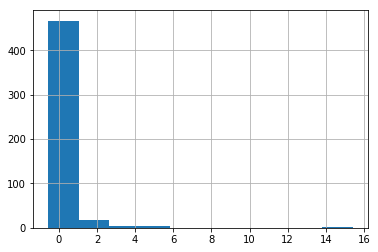

In [28]:
Y.hist()

## Using Weight Initializers

##  He Initialization

Let's try and use a weight initializer. In the lecture, we've seen the He normalizer, which initializes the weight vector to have an average 0 and a variance of 2/n, with $n$ the number of features feeding into a layer.

In [35]:
np.random.seed(123)
model = Sequential()
model.add(layers.Dense(8, input_dim=12, kernel_initializer= "he_normal",
                activation='relu'))
model.add(layers.Dense(1, activation = 'linear'))

model.compile(optimizer= "sgd" ,loss='mse',metrics=['mse'])
hist = model.fit(X_train, Y_train, batch_size=32, 
                 epochs=100, validation_data = (X_val, Y_val),verbose=0)

In [36]:
pred_train = model.predict(X_train).reshape(-1)
pred_val = model.predict(X_val).reshape(-1)

MSE_train = np.mean((pred_train-Y_train)**2)
MSE_val = np.mean((pred_val-Y_val)**2)

In [37]:
print(MSE_train)
print(MSE_val)

0.924555923091105
0.9991927982052867


The initializer does not really help us to decrease the MSE. We know that initializers can be particularly helpful in deeper networks, and our network isn't very deep. What if we use the `Lecun` initializer with a `tanh` activation?

## Lecun Initialization

In [38]:
np.random.seed(123)
model = Sequential()
model.add(layers.Dense(8, input_dim=12, 
                kernel_initializer= "lecun_normal", activation='tanh'))
model.add(layers.Dense(1, activation = 'linear'))

model.compile(optimizer= "sgd" ,loss='mse',metrics=['mse'])
hist = model.fit(X_train, Y_train, batch_size=32, 
                 epochs=100, validation_data = (X_val, Y_val), verbose=0)

In [39]:
pred_train = model.predict(X_train).reshape(-1)
pred_val = model.predict(X_val).reshape(-1)

MSE_train = np.mean((pred_train-Y_train)**2)
MSE_val = np.mean((pred_val-Y_val)**2)

In [40]:
print(MSE_train)
print(MSE_val)

0.9451289998621167
0.9866754226484686


Not much of a difference, but a useful note to consider when tuning your network. Next, let's investigate the impace of various optimization algorithms.

## RMSprop

In [41]:
np.random.seed(123)
model = Sequential()
model.add(layers.Dense(8, input_dim=12, activation='relu'))
model.add(layers.Dense(1, activation = 'linear'))

model.compile(optimizer= "rmsprop" ,loss='mse',metrics=['mse'])
hist = model.fit(X_train, Y_train, batch_size=32, 
                 epochs=100, validation_data = (X_val, Y_val), verbose = 0)

In [42]:
pred_train = model.predict(X_train).reshape(-1)
pred_val = model.predict(X_val).reshape(-1)

MSE_train = np.mean((pred_train-Y_train)**2)
MSE_val = np.mean((pred_val-Y_val)**2)

In [43]:
print(MSE_train)
print(MSE_val)

0.9187002476363131
0.9075237502261114


## Adam

In [44]:
np.random.seed(123)
model = Sequential()
model.add(layers.Dense(8, input_dim=12, activation='relu'))
model.add(layers.Dense(1, activation = 'linear'))

model.compile(optimizer= "Adam" ,loss='mse',metrics=['mse'])
hist = model.fit(X_train, Y_train, batch_size=32, 
                 epochs=100, validation_data = (X_val, Y_val), verbose = 0)

In [45]:
pred_train = model.predict(X_train).reshape(-1)
pred_val = model.predict(X_val).reshape(-1)

MSE_train = np.mean((pred_train-Y_train)**2)
MSE_val = np.mean((pred_val-Y_val)**2)

In [46]:
print(MSE_train)
print(MSE_val)

0.9205551777047531
0.9036722777237326


## Learning Rate Decay with Momentum


In [47]:
np.random.seed(123)
sgd = optimizers.SGD(lr=0.03, decay=0.0001, momentum=0.9)
model = Sequential()
model.add(layers.Dense(8, input_dim=12, activation='relu'))
model.add(layers.Dense(1, activation = 'linear'))

model.compile(optimizer= sgd ,loss='mse',metrics=['mse'])
hist = model.fit(X_train, Y_train, batch_size=32, 
                 epochs=100, validation_data = (X_val, Y_val), verbose = 0)

In [48]:
pred_train = model.predict(X_train).reshape(-1)
pred_val = model.predict(X_val).reshape(-1)

MSE_train = np.mean((pred_train-Y_train)**2)
MSE_val = np.mean((pred_val-Y_val)**2)

In [49]:
print(MSE_train)
print(MSE_val)

0.8451498606459134
0.9522933827115981


## Additional Resources
* https://github.com/susanli2016/Machine-Learning-with-Python/blob/master/Consumer_complaints.ipynb  

* https://catalog.data.gov/dataset/consumer-complaint-database  

* https://machinelearningmastery.com/dropout-regularization-deep-learning-models-keras/  

* https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/  

* https://machinelearningmastery.com/regression-tutorial-keras-deep-learning-library-python/  

* https://stackoverflow.com/questions/37232782/nan-loss-when-training-regression-network  

* https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/


## Summary  

In this lab, we began to practice some of the concepts regarding normalization and optimization for neural networks. In the final lab for this section, you'll independently practice these concepts on your own in order to tune a model to predict individuals payments to loans.